## Comparing Landsat and PlanetScope Scenes

A common and powerful workflow for analysis is comparing or combining information from multiple sources. This tutorial demonstrates comparing a set of Landsat and PlanetScope scenes.

In this tutorial, we download scenes from the two sensors taken on the same day at the same place, visualize them, resample the Landsat scene to match the pixel resolution and locations of the PlanetScope scene, and perform pixel-by-pixel comparison of their near-infrared (NIR) bands.

Our comparison of the NIR bands is identification of the difference between the scaled NIR bands. We find that most differences between the NIR bands are at high-resolution features and are due to the lower resolution of the Landsat scene. However, we also find a few fields show noticeable difference in the NIR bands. We theorize that these differences may be due to the different spectral responses of the two sensors and the fields containing different crop types than the surrounding fields. These results suggest that an analysis utilizing both Landsat8 and PlanetScope scenes may be able to better differentiate crop types than just using one sensor.

Ideas for extending beyond this notebook:
1. Mask the scenes using the PlanetScope Unusable Data Mask and Landsat Quality Assurance bands
2. Convert the PlanetScope scene to reflectance and then do not normalize the bands in the difference calculation


## Install Dependencies and Set up Notebook

In [1]:
import os
import shutil
from subprocess import check_output, STDOUT, CalledProcessError
from six.moves import urllib

import numpy as np
import rasterio
import rasterio.enums
import rasterio.vrt
import requests

%matplotlib inline

## Download Scenes

In the [crossovers notebook](../crossovers/ps_l8_crossovers.ipynb), we identified many Landsat/PlanetScope crossovers within the same day that occured between January and August 2017. From that list, we are going to download the following set of scenes: 
 - [PSOrthoTile 644787_1056721_2017-07-25_0f52](https://api.planet.com/data/v1/item-types/PSOrthoTile/items/644787_1056721_2017-07-25_0f52/thumb)
 - [Landsat8L1G LC80430332017206LGN00](https://api.planet.com/data/v1/item-types/Landsat8L1G/items/LC80430332017206LGN00/thumb)


|PSOrthoTile                           | Landsat8L1G |
|:------------------------------------:|:-------------------------:|
|![644787_1056721_2017-07-25_0f52][ps] |  ![LC80430332017206LGN00][l8]|

[ps]: images/644787_1056721_2017-07-25_0f52_thumb.png "644787_1056721_2017-07-25_0f52"
[l8]: images/LC80430332017206LGN00_thumb.png "LC80430332017206LGN00"


These scenes represent a crossover between Landsat8 and PlanetScope on July 25, 2017.

For the Landsat8L1G scene, we download band 5, which is the NIR band ([ref](https://landsat.usgs.gov/what-are-band-designations-landsat-satellites)).

To download the scenes, we use the planet CLI because it handles activating, waiting for activation, and downloading the file.

We will save the scenes in the `data` folder. This folder isn't tracked by git so the downloaded image file will not bloat our git repository.

### Download PlanetScope Orthotile Scene

In [2]:
# Create a working directory if it does not already exist.
data_folder = 'data'
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

In [3]:
# First test if scene file exists, if not, use the Planet commandline tool to download the image.
# This command assumes a bash shell, available in Unix-based operating systems.
!test -f data/644787_1056721_2017-07-25_0f52_BGRN_Analytic.tif || \
    planet data download \
        --item-type PSOrthoTile \
        --asset-type analytic \
        --string-in id 644787_1056721_2017-07-25_0f52 \
        --dest data

In [4]:
# Store the image filename for processing and make sure the file exists.
pl_filename = os.path.join('data', '644787_1056721_2017-07-25_0f52_BGRN_Analytic.tif')
print(pl_filename)
assert os.path.isfile(pl_filename)

data/644787_1056721_2017-07-25_0f52_BGRN_Analytic.tif


### Download Landsat NIR Band

Landsat is distributed with each asset as an individual band. Band 5 is the NIR band. Since we only plan on using the NIR band, we will download just that asset.

NOTE: The command below should work, but currently there is a bug in the planet CLI.
Until that is fixed, use the curl command to download the asset from the endpoint directly.

In [5]:
# !planet data download \
#     --item-type Landsat8L1G \
#     --asset-type analytic_b5 \
#     --string-in id LC80430332017206LGN00 \
#     --dest data/

# !ls -l --block-size=M data/

In [6]:
# The long way of downloading an asset. Doesn't use the planet CLI

def get_auth():
    auth = (os.environ['PL_API_KEY'], '')
    return auth

def get_asset_info(asset):
    auth = get_auth()
    item_assets_url = 'https://api.planet.com/data/v1/item-types/Landsat8L1G/items/LC80430332017206LGN00/assets/'
    r = requests.get(item_assets_url, auth=auth)
    assert r.status_code == 200
    assets_resp = r.json()
    return assets_resp[asset]

def activate(asset):
    asset_info = get_asset_info(asset)
    activation_link = asset_info['_links']['activate']
    auth = get_auth()
    r = requests.post(activation_link, auth=auth)
    assert r.status_code == 204

def download(asset, path):
    if not os.path.isfile(path):
        asset_info = get_asset_info(asset)
        download_link = asset_info['location']
        urllib.request.urlretrieve(download_link, path)

asset = 'analytic_b5'
activate(asset)

# it may take a while for the asset to be activated. If this fails, wait a while and rerun
landsat_filename = os.path.join('data', 'LC80430332017206LGN00_{}.tif'.format(asset))
download(asset, landsat_filename)

In [7]:
# store the Landsat band filename for processing and make sure the file exists
l8_nir_orig_filename = os.path.join('data', 'LC80430332017206LGN00_analytic_b5.tif')
print(l8_nir_orig_filename)
assert os.path.isfile(l8_nir_orig_filename)

data/LC80430332017206LGN00_analytic_b5.tif


## Warp Landsat Scene to Planet Scene

For pixel-by-pixel comparison of the Landsat and Planet scenes, the two scenes must have the same extents, the pixels must be the same size, and the pixels must exactly overlap each other. This can all be achieved by warping one scene to the other scene. We warp the Landsat scene to the Planet scene because the Planet scene is much higher resolution than the Landsat scene and we want to use the highest resolution possible for our comparison.

The GDAL command-line interface, specifically [gdalwarp](http://www.gdal.org/gdalwarp.html), is the easiest way to warp one image to another image.

In [8]:
def prepare_l8_band(band_filename, dst_filename, out_filename):
    
    """Project, crop, and resample landsat 8 band to match dst_filename image."""
    
    # Open the Landsat8 band file.
    with rasterio.open(band_filename) as src:
        
        # Open the Planet image to use as a template.
        with rasterio.open(dst_filename) as pl:
            
            # A Virtual Raster (VRT) allows for describing raster transformations and delaying computation
            # until data is accessed.  The WarpedVRT() class describes how to warp a dataset, but the
            # reprojection calculations are not transformed, and they are only transformed
            
            # These parameters define a target image in the same coordinate reference system as the
            # PlanetScope image and the same number of rows and columns.
            warp_params = {
                'crs': pl.crs,
                'transform': pl.transform,
                'width': pl.width,
                'height': pl.height
            }
            with rasterio.vrt.WarpedVRT(src, **warp_params) as vrt:
                
                # Using the PlanetScope image as a reference, create an output.  The PlanetScope image
                # has 4 bands but the Landsat 8 image only has 1.  Update the output image profile with
                # this information.
                out_profile = pl.profile.copy()
                out_profile['count'] = vrt.count
                with rasterio.open(out_filename, 'w', **out_profile) as dst:
                    # This 'vrt.read()' triggers the warp calculations.
                    data = vrt.read()
                    
                    # Write data to output file.
                    dst.write(data)

                
l8_nir_filename = os.path.join('data', 'LC80430332017206LGN00_analytic_b5_warped.tif')
prepare_l8_band(l8_nir_orig_filename, pl_filename, l8_nir_filename)

## Load and Visualize NIR Bands

Before moving on to comparing the NIR bands, we load the NIR bands from each scene and visualize the bands.

Instead of including a huge chunk of code for visualizing the NIR band, we put that code in a local script ([visual.py](visual.py)) and import here.

Ideally, we would use the PlanetScope Unusable Data Mask (UDM) and Landsat Quality Assurance (QA) bands to create the pixel masks. In the interest of keeping this tutorial focused, we perform a simple and brute-force masking where we mask pixels that are equal to the blackfill NoData value, 0. 

In [9]:
import visual

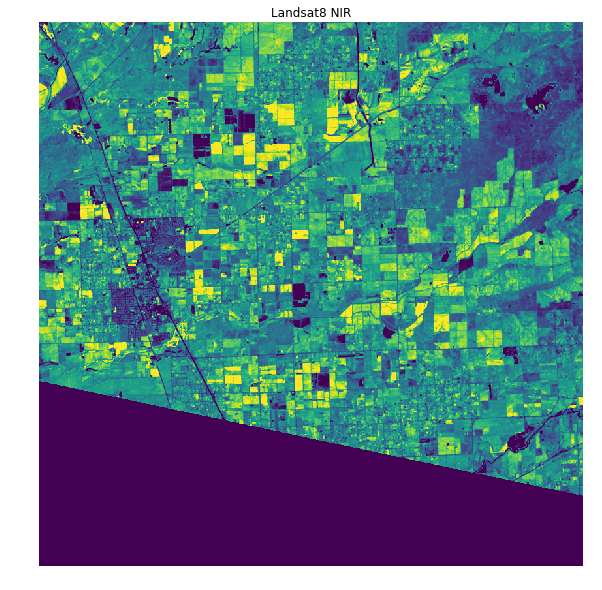

In [10]:
# Display Landsat 8 NIR band.

with rasterio.open(l8_nir_filename, 'r') as src:
    
    data = src.read(1)
    
    # Generate a masked array with a mask representing 0 pixels.
    mask = data == 0
    l8_nir_band = np.ma.array(data, mask=mask)

visual.plot_image(l8_nir_band, title='Landsat8 NIR')

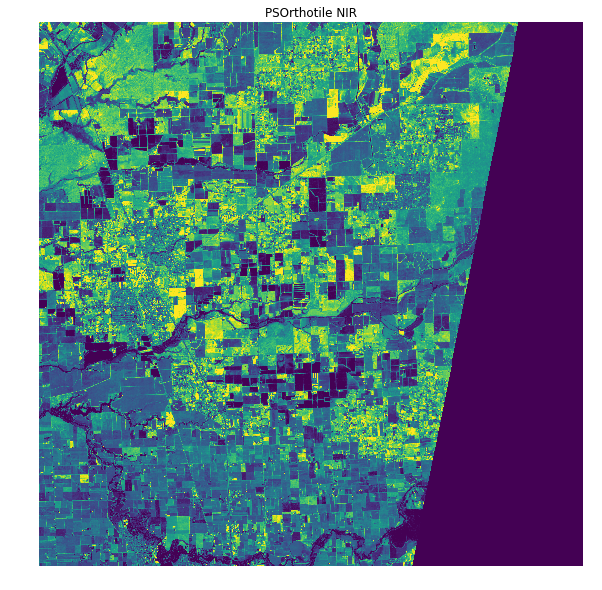

In [11]:
# Display PlanetScope NIR band.

with rasterio.open(pl_filename, 'r') as src:
    data = src.read(3)
    mask = data == 0
    pl_nir_band = np.ma.array(data, mask=mask)

visual.plot_image(pl_nir_band, title='PSOrthotile NIR')

## Compare NIR Bands

In this section we look at the difference in response between the NIR bands of the two sensors.

The difference is calculated as the absolute value of the subtraction of one normalized NIR band from the other normalized NIR band.

Note: Landsat8 is corrected to reflectance and PlanetScope is corrected to radiance. The conversion between reflectance and radiance is achieved by scaling the entire band. In this comparison, we normalize the two NIR bands to 0-1 anyway, so the radiance/reflectance difference doesn't affect us.

In [12]:
def rescale(ndarray, old_min=None, old_max=None, new_min=0, new_max=1):
    if old_min is None:
        old_min = ndarray.min()
    if old_max is None:
        old_max = ndarray.max()

    # https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray.astype(np.float) - old_min) * (new_max - new_min) / (old_max - old_min) + new_min

In [13]:
# Scale the bands so that the maximum value is 1
diff_band = abs(rescale(l8_nir_band, old_min=0) - rescale(pl_nir_band, old_min=0))

# Mask a pixel in the difference band if it is masked in either the Landsat 8 or PlanetScope data.
diff_band.mask = l8_nir_band.mask | pl_nir_band.mask

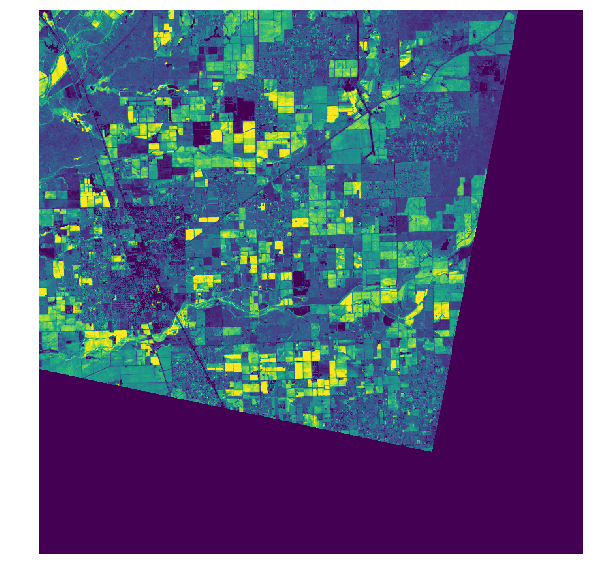

In [14]:
visual.plot_image(diff_band)

In general, the major differences between the NIR bands occur at high-resolution features (edges of fields, roads, and populated areas) and are caused by the lower resolution of the Landsat8 sensor. However, there are a few larger regions, which appear to be fields, that show some difference between the NIR bands.

Lets zoom into one such region, the square field located just right of center of the image.

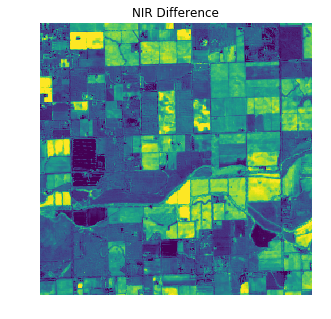

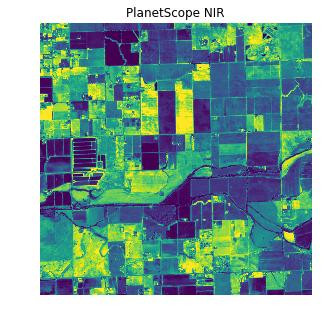

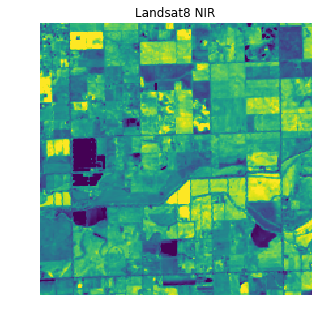

In [15]:
region = (np.s_[3000:5000], np.s_[3500:5500]) # create a (rows, columns) numpy slice for indexing the array
figsize = (5, 5)
visual.plot_image(diff_band[region], title='NIR Difference', figsize=figsize)
visual.plot_image(pl_nir_band[region], title='PlanetScope NIR', figsize=figsize)
visual.plot_image(l8_nir_band[region], title='Landsat8 NIR', figsize=figsize)

Interestingly, it appears the square field which pops out in the difference image is less differentiated from the surrounding fields in the Landsat scene than in the PlanetScope scene. Since both scenes were collected on the same day, this is likely due to a different in the spectral responses of the NIR bands for the two sensors combined with the crop type of that field. The center wavelength of the NIR response for the PlanetScope sensor is 825nm, while it is [865nm for the Landsat sensor](https://landsat.gsfc.nasa.gov/preliminary-spectral-response-of-the-operational-land-imager-in-band-band-average-relative-spectral-response/). This shows that an analysis utilizing both Landsat8 and PlanetScope scenes may be able to better differentiate crop types. There is great potential in combining scenes from multiple sensors for analysis.